In [26]:
import pandas as pd
import numpy as np
from yieldCurvePrediction import yieldCurvePredictor
from Models.ECIR_new import ECIRModel
from Models.CIRModel import BasicCIRModel

In [27]:
class strategy:

    def __init__(self, model, dates, data):

        self.model = model
        self.dates = dates
        self.data = data

    def prices(self):

        mod_dict = {}
        price_dict = {}
        
        for date in self.dates:
    
            mod_dict[date] = yieldCurvePredictor(self.model, date, self.data) 
            price_dict[date] = mod_dict[date].comb_data()[1]
    
        return price_dict

    def buy_sell(self):

        prices = self.prices()
    
        for date in self.dates:
    
            bonds = []
        
            for bond in prices[date].index:
                if prices[date]['Simulated Prices'][bond] < prices[date]['Actual Prices'][bond]:
                    bonds.append(-1)
                else:
                   bonds.append(1)
            prices[date]['Buy?'] = bonds 

        return prices

    def profit(self, cash = 1000000):

        prices = self.buy_sell()
        weights = 1 / len(prices[self.dates[0]])
        value = weights*cash
        invested = np.zeros(len(prices[self.dates[0]]))
        shares = np.zeros(len(prices[self.dates[0]]))
        profit = np.zeros(len(prices[self.dates[0]]))
        prices = self.buy_sell()
        
        for i in range(len(self.dates)):

            errs = pd.DataFrame({'Error' :np.abs(prices[self.dates[i]]['Actual Prices'] - prices[self.dates[i]]['Simulated Prices'])})

            errs = errs.sort_values(by = 'Error')
            errs['Invest?'] = np.zeros(len(errs))
            new_index = errs.index
            index_ones = new_index[:5]
            index_zeros = new_index[5:]
            errs['Invest?'][index_ones] = np.ones(5)
            errs['Invest?'][index_zeros] = np.zeros(len(errs) - 5)

            prices[dates[i]] = prices[dates[i]].join(errs)
            
            for j in range(len(prices[self.dates[i]]['Actual Prices'])):
                
                profit[j] += (shares[j] * prices[self.dates[i]]['Actual Prices'][j]) - invested[j]
                yesterday_invested = np.sum(invested)
                
                shares[j] = np.floor(value / prices[self.dates[i]]['Actual Prices'][j]) * prices[self.dates[i]]['Invest?'][j]
                invested[j] = (shares[j] * prices[self.dates[i]]['Actual Prices'][j]) * prices[self.dates[i]]['Invest?'][j]
                
                if prices[self.dates[i]]['Buy?'][j] == -1:
                    invested[j] *= -1
                    shares[j] *= -1
        
            cash += (np.sum(profit) + yesterday_invested - np.sum(invested))
            value = weights*cash

        return pd.DataFrame({'Profit' : profit}).set_index(prices[dates[0]].index)

In [28]:
# Load the DGS_30 data
dgs_30_data = pd.read_csv('Data Folder/DGS_30.csv')
# Load the DGS3MO data
dgs3mo_data = pd.read_csv('Data Folder/DGS3MO.csv')

# Convert the 'DATE' column to datetime and set it as index for both DataFrames
dgs_30_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
dgs_30_data['Date'] = pd.to_datetime(dgs_30_data['Date'])
dgs_30_data.set_index('Date', inplace=True)

dgs3mo_data.rename(columns={'DATE': 'Date'}, inplace=True)
dgs3mo_data['Date'] = pd.to_datetime(dgs3mo_data['Date'])
dgs3mo_data.set_index('Date', inplace=True)

# Insert the DGS3MO data into the DGS_30 data as the first column
dgs_30_data.insert(0, 'DGS3MO', dgs3mo_data['DGS3MO'])

data=dgs_30_data

dates = data.loc[data.index >= '2024-03-15'].index

params_ecir = {
    "kappa": 4.989,
    "mu_r": 0.05481,
    "sigma": 0.01116,
    "mu": 0.00000,
    "gamma": 0.05628
}

params_cir = {
    'kappa': 0.0565,
    'mu_r': 0.0996,
    'sigma': 0.0124
}

# MLE RESULTS

In [29]:
cir_ann = []
ecir_ann = []
all_profs = []

for i in range(50):
    CIR = strategy(BasicCIRModel(**params_cir), dates, data)
    ECIR = strategy(ECIRModel(**params_ecir), dates, data)
            
    CIR_profit = CIR.profit(1000000).rename(columns = {'Profit' : 'CIR'})
    ECIR_profit = ECIR.profit(1000000).rename(columns = {'Profit' : 'ECIR'})
    
    profits = pd.concat([CIR_profit, ECIR_profit], axis = 1)

    cir_ann.append((np.sum(profits)*100*12/1000000)[0])
    ecir_ann.append((np.sum(profits)*100*12/1000000)[1])
    all_profs.append(profits)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Annualized Profit (%)')

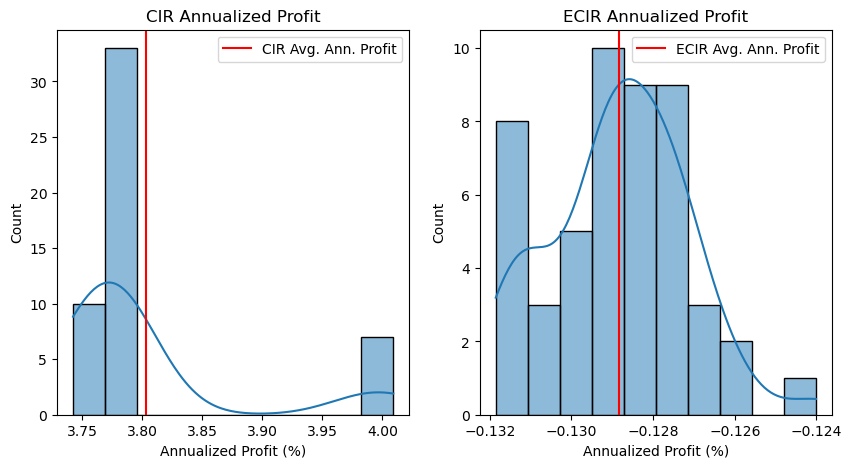

In [31]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.histplot(cir_ann, bins = 10, kde = True)
plt.axvline(np.mean(cir_ann), color = 'red', label = 'CIR Avg. Ann. Profit')
plt.legend()
plt.title('CIR Annualized Profit')
plt.xlabel('Annualized Profit (%)')
plt.subplot(1, 2, 2)
sns.histplot(ecir_ann, bins = 10, kde = True)
plt.axvline(np.mean(ecir_ann), color = 'red', label = 'ECIR Avg. Ann. Profit')
plt.legend()
plt.title('ECIR Annualized Profit')
plt.xlabel('Annualized Profit (%)')

In [32]:
print('CIR Average Annualized Profit:', str(round(np.mean(cir_ann), 2)), '%')
print('ECIR Average Annualized Profit:', str(round(np.mean(ecir_ann), 2)), '%')

CIR Average Annualized Profit: 3.8 %
ECIR Average Annualized Profit: -0.13 %


# YIELD CURVE RESULTS

In [33]:
params_ecir = {
    "kappa": 3.071,    
    "mu_r": 0.007668,     
    "sigma": 0.3419,    
    "mu": 0.08226,      
    "gamma": 0.04355            
}

params_cir = {
    'kappa': 1.2310,
    'mu_r': 0.0459,
    'sigma': 0.1410
}

cir_ann = []
ecir_ann = []
all_profs = []

for i in range(50):
    CIR = strategy(BasicCIRModel(**params_cir), dates, data)
    ECIR = strategy(ECIRModel(**params_ecir), dates, data)
            
    CIR_profit = CIR.profit(1000000).rename(columns = {'Profit' : 'CIR'})
    ECIR_profit = ECIR.profit(1000000).rename(columns = {'Profit' : 'ECIR'})
    
    profits = pd.concat([CIR_profit, ECIR_profit], axis = 1)

    cir_ann.append((np.sum(profits)*100*12/1000000)[0])
    ecir_ann.append((np.sum(profits)*100*12/1000000)[1])
    all_profs.append(profits)

Text(0.5, 0, 'Annualized Profit (%)')

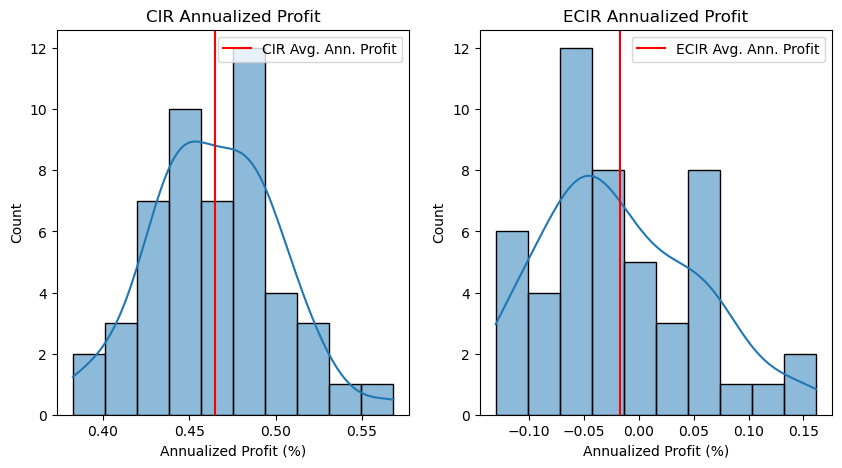

In [34]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.histplot(cir_ann, bins = 10, kde = True)
plt.axvline(np.mean(cir_ann), color = 'red', label = 'CIR Avg. Ann. Profit')
plt.legend()
plt.title('CIR Annualized Profit')
plt.xlabel('Annualized Profit (%)')
plt.subplot(1, 2, 2)
sns.histplot(ecir_ann, bins = 10, kde = True)
plt.axvline(np.mean(ecir_ann), color = 'red', label = 'ECIR Avg. Ann. Profit')
plt.legend()
plt.title('ECIR Annualized Profit')
plt.xlabel('Annualized Profit (%)')

In [35]:
print('CIR Average Annualized Profit:', str(round(np.mean(cir_ann), 2)), '%')
print('ECIR Average Annualized Profit:', str(round(np.mean(ecir_ann), 2)), '%')

CIR Average Annualized Profit: 0.46 %
ECIR Average Annualized Profit: -0.02 %
